In [21]:
import pandas as pd
import numpy as np
from fredapi import Fred
from datetime import datetime, timedelta
from io import StringIO

# --- Configuration ---
FRED_API_KEY = '856a3fcb406be3d3ab15dd7eed28ec7c' # Replace with your actual key if different
HISTORY_YEARS = 10  # For Z-score calculation and historical context
REPORT_FILE_NAME = "macro_sector_report_final_updated.txt" # Changed filename for clarity

# --- Main Class for Report Generation ---
class MacroEconomicReporter:
    def __init__(self, api_key, history_years=10):
        self.fred = Fred(api_key=api_key)
        self.history_start_date = (datetime.now() - timedelta(days=history_years * 365.25)).strftime('%Y-%m-%d')
        self.history_years = history_years
        self.report_content = StringIO()

    def _print_to_report(self, message=""):
        print(message, file=self.report_content)
        print(message) # Also print to console for real-time feedback

    def fetch_and_analyze_series(self, series_id, name, unit="", higher_is_better=None, is_pmi=False, target_freq='M'):
        """
        Fetches, processes, and analyzes a single FRED series.
        Returns a dictionary with key metrics or None if data is unavailable.
        """
        try:
            self._print_to_report(f"  Fetching {name} ({series_id}, Target Freq: {target_freq})...")
            series_data = self.fred.get_series(series_id, observation_start=self.history_start_date)
            series_data = series_data.dropna()

            if series_data.empty:
                self._print_to_report(f"    Warning: No data for {series_id} ({name}).")
                return {
                    "name": name, "id": series_id, "unit": unit, "target_freq": target_freq,
                    "latest_value": "N/A", "latest_date": "N/A",
                    "yoy_change": "N/A", "prev_period_change_str": "N/A", "prev_period_label": "N/A",
                    "z_score": "N/A", "interpretation": "Data Missing"
                }

            original_freq_str = pd.infer_freq(series_data.index) # Store original for logging if needed

            # Resample to target frequency if necessary
            if original_freq_str: # Only resample if a frequency can be inferred
                if target_freq == 'M':
                    if any(f_char in original_freq_str.upper() for f_char in ['D', 'B', 'W']):
                        series_data = series_data.resample('ME').mean()
                    elif 'Q' in original_freq_str.upper():
                        series_data = series_data.resample('ME').ffill()
                elif target_freq == 'Q':
                    if 'M' in original_freq_str.upper(): # Example: Average monthly to quarterly
                        series_data = series_data.resample('QE').mean()
                    elif any(f_char in original_freq_str.upper() for f_char in ['D', 'B', 'W']):
                        series_data = series_data.resample('QE').mean()
                elif target_freq == 'A': # Annual
                    if 'Q' in original_freq_str.upper():
                        series_data = series_data.resample('YE').mean() # Or .last() depending on series
                    elif 'M' in original_freq_str.upper():
                        series_data = series_data.resample('YE').mean()
                    elif any(f_char in original_freq_str.upper() for f_char in ['D', 'B', 'W']):
                         series_data = series_data.resample('YE').mean()


            series_data = series_data.dropna()
            if series_data.empty:
                 self._print_to_report(f"    Warning: No data for {series_id} ({name}) after resampling from {original_freq_str} to {target_freq}.")
                 return {
                    "name": name, "id": series_id, "unit": unit, "target_freq": target_freq,
                    "latest_value": "N/A", "latest_date": "N/A",
                    "yoy_change": "N/A", "prev_period_change_str": "N/A", "prev_period_label": "N/A",
                    "z_score": "N/A", "interpretation": "Data Missing after resample"
                }

            series_data = series_data.sort_index()
            latest_value = series_data.iloc[-1]
            latest_date = series_data.index[-1].strftime('%Y-%m-%d')

            yoy_periods = 0
            if target_freq == 'M': yoy_periods = 12
            elif target_freq == 'Q': yoy_periods = 4
            elif target_freq == 'A': yoy_periods = 1

            yoy_change_val = np.nan
            if yoy_periods > 0 and len(series_data) >= (yoy_periods + 1):
                yoy_change_val = (series_data.iloc[-1] / series_data.iloc[-(yoy_periods + 1)] - 1) * 100
                yoy_change_str = f"{yoy_change_val:.2f}%"
            else:
                yoy_change_str = f"N/A (Insufficient Data for {target_freq} YoY)"

            prev_period_change_val = np.nan
            prev_period_label = "Prev. Period"
            if target_freq == 'M': prev_period_label = "MoM"
            elif target_freq == 'Q': prev_period_label = "QoQ"
            elif target_freq == 'A': prev_period_label = "YoY (vs prev year)" # For annual data, "previous period" is previous year

            if len(series_data) >= 2:
                prev_period_change_val = (series_data.iloc[-1] / series_data.iloc[-2] - 1) * 100
                prev_period_change_str = f"{prev_period_change_val:.2f}%"
            else:
                prev_period_change_str = "N/A (Insufficient Data)"

            mean_val = series_data.mean()
            std_val = series_data.std()
            z_score_val = np.nan
            if std_val == 0 or pd.isna(std_val) or std_val < 1e-9: # Adjusted for very small std dev
                z_score_val = 0
                z_score_str = "0.00 (Constant/Near-Constant Data)"
            else:
                z_score_val = (latest_value - mean_val) / std_val
                z_score_str = f"{z_score_val:.2f}"

            interpretation_parts = []
            if pd.notna(yoy_change_val):
                if yoy_change_val > 1: interpretation_parts.append(f"Growing YoY ({target_freq})")
                elif yoy_change_val < -1: interpretation_parts.append(f"Shrinking YoY ({target_freq})")
                else: interpretation_parts.append(f"Stable YoY ({target_freq})")

            if pd.notna(prev_period_change_val):
                threshold = 0.5 if target_freq == 'M' else (0.2 if target_freq == 'Q' else 0.1) # Smaller threshold for Q/A
                if prev_period_change_val > threshold: interpretation_parts.append(f"Rising {prev_period_label}")
                elif prev_period_change_val < -threshold: interpretation_parts.append(f"Falling {prev_period_label}")

            if pd.notna(z_score_val):
                if z_score_val > 1.5: interpretation_parts.append(f"Very High (vs {self.history_years}yr avg)")
                elif z_score_val > 0.75: interpretation_parts.append(f"High (vs {self.history_years}yr avg)")
                elif z_score_val < -1.5: interpretation_parts.append(f"Very Low (vs {self.history_years}yr avg)")
                elif z_score_val < -0.75: interpretation_parts.append(f"Low (vs {self.history_years}yr avg)")
                else: interpretation_parts.append(f"Neutral (vs {self.history_years}yr avg)")

            if is_pmi: # This flag is specific to PMI style indices (e.g. ISM)
                if latest_value > 52: interpretation_parts.append("Strong Expansion")
                elif latest_value > 50: interpretation_parts.append("Expansion")
                elif latest_value < 48: interpretation_parts.append("Strong Contraction")
                elif latest_value < 50: interpretation_parts.append("Contraction")
                else: interpretation_parts.append("Neutral (near 50)")

            interpretation = "; ".join(interpretation_parts) if interpretation_parts else "Neutral"

            return {
                "name": name, "id": series_id, "unit": unit, "target_freq": target_freq,
                "latest_value": f"{latest_value:.2f}", "latest_date": latest_date,
                "yoy_change": yoy_change_str,
                "prev_period_change_str": prev_period_change_str, "prev_period_label": prev_period_label,
                "z_score": z_score_str, "interpretation": interpretation
            }
        except Exception as e:
            self._print_to_report(f"    Error processing {series_id} ({name}): {e}")
            return {
                "name": name, "id": series_id, "unit": unit, "target_freq": target_freq,
                "latest_value": "Error", "latest_date": "Error",
                "yoy_change": "Error", "prev_period_change_str": "Error", "prev_period_label": "Error",
                "z_score": "Error", "interpretation": f"Processing Error: {e}"
            }

    def generate_report(self, general_indicators, sector_indicators_map):
        self._print_to_report(f"--- Macroeconomic & Sector Snapshot ---")
        self._print_to_report(f"Report Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        self._print_to_report(f"Historical Context: Based on the last {self.history_years} years of data.")
        self._print_to_report(f"Note: 'YoY Change' compares the latest period to the same period in the previous year")
        self._print_to_report(f"      (e.g., Q2 2023 vs Q2 2022 for Quarterly data, or May 2023 vs May 2022 for Monthly data).")
        self._print_to_report(f"      'Previous Period Change' (labeled as MoM, QoQ, etc.) refers to the change from the")
        self._print_to_report(f"      immediately preceding period at the target frequency of the indicator.")
        self._print_to_report("\n" + "="*60 + "\n")

        self._print_to_report("I. GENERAL MACROECONOMIC OVERVIEW")
        self._print_to_report("-" * 40)
        for indicator in general_indicators:
            self._print_to_report(f"\nIndicator: {indicator['name']} ({indicator['id']})")
            analysis = self.fetch_and_analyze_series(
                indicator['id'], indicator['name'], indicator.get('unit', ''),
                indicator.get('higher_is_better'), indicator.get('is_pmi', False),
                indicator.get('target_freq', 'M') # Default target_freq 'M' if not in dict
            )
            if analysis:
                self._print_to_report(f"  Target Freq:  {analysis['target_freq']}")
                self._print_to_report(f"  Latest Value: {analysis['latest_value']} {analysis.get('unit','')} (as of {analysis['latest_date']})")
                self._print_to_report(f"  YoY Change:   {analysis['yoy_change']}")
                self._print_to_report(f"  {analysis['prev_period_label']} Change:   {analysis['prev_period_change_str']}")
                self._print_to_report(f"  Z-Score:      {analysis['z_score']} (vs last {self.history_years}yr avg)")
                self._print_to_report(f"  Interpretation: {analysis['interpretation']}")

        self._print_to_report("\n" + "="*60 + "\n")
        self._print_to_report("II. SECTOR-SPECIFIC INDICATORS")
        for sector, indicators in sector_indicators_map.items():
            self._print_to_report("\n" + "-"*40)
            self._print_to_report(f"Sector: {sector.upper()}")
            self._print_to_report("-" * 40)
            for indicator in indicators:
                self._print_to_report(f"\nIndicator: {indicator['name']} ({indicator['id']})")
                analysis = self.fetch_and_analyze_series(
                    indicator['id'], indicator['name'], indicator.get('unit', ''),
                    indicator.get('higher_is_better'), indicator.get('is_pmi', False),
                    indicator.get('target_freq', 'M') # Default target_freq 'M' if not in dict
                )
                if analysis:
                    self._print_to_report(f"  Target Freq:  {analysis['target_freq']}")
                    self._print_to_report(f"  Latest Value: {analysis['latest_value']} {analysis.get('unit','')} (as of {analysis['latest_date']})")
                    self._print_to_report(f"  YoY Change:   {analysis['yoy_change']}")
                    self._print_to_report(f"  {analysis['prev_period_label']} Change:   {analysis['prev_period_change_str']}")
                    self._print_to_report(f"  Z-Score:      {analysis['z_score']} (vs last {self.history_years}yr avg)")
                    self._print_to_report(f"  Interpretation: {analysis['interpretation']}")

        self._print_to_report("\n" + "="*60)
        self._print_to_report("--- END OF REPORT ---")

        report_string = self.report_content.getvalue()
        self.report_content.close()
        return report_string

# --- Indicator Definitions ---

# 1. General Macroeconomic Indicators
GENERAL_MACRO_INDICATORS = [
    # Growth & Output
    {"id": "GDPC1", "name": "Real GDP", "unit": "$ Trillions (Chained 2017)", "target_freq": "Q"},
    {"id": "BBKMLEIX", "name": "US Leading Economic Index (LEI)", "unit": "Index", "target_freq": "M"},
    # Inflation
    {"id": "CPIAUCSL", "name": "Consumer Price Index (All Urban)", "unit": "Index", "target_freq": "M"},
    {"id": "CPIULFSL", "name": "Core CPI (Less Food & Energy)", "unit": "Index", "target_freq": "M"},
    {"id": "PPIACO", "name": "Producer Price Index (All Commodities)", "unit": "Index", "target_freq": "M"},
    {"id": "PCEPI", "name": "Personal Consumption Expenditures Price Index", "unit": "Index", "target_freq": "M"},
    {"id": "PCEPILFE", "name": "Core PCE Price Index", "unit": "Index", "target_freq": "M"},
    # Labor Market
    {"id": "UNRATE", "name": "Unemployment Rate", "unit": "%", "target_freq": "M"},
    {"id": "PAYEMS", "name": "All Employees, Total Nonfarm (Payroll)", "unit": "Thousands", "target_freq": "M"},
    {"id": "ICSA", "name": "Initial Claims (Unemployment Insurance)", "unit": "Count", "target_freq": "M"},
    {"id": "CCSA", "name": "Continued Claims (Unemployment Insurance)", "unit": "Count", "target_freq": "M"},
    {"id": "JTSJOL", "name": "Job Openings: Total Nonfarm (JOLTS)", "unit": "Thousands", "target_freq": "M"},
    # Consumer
    {"id": "UMCSENT", "name": "Consumer Sentiment (U. of Michigan)", "unit": "Index", "target_freq": "M"},
    {"id": "DSPIC96", "name": "Real Disposable Personal Income", "unit": "$ Billions (Chained 2017)", "target_freq": "M"},
    {"id": "PSAVERT", "name": "Personal Saving Rate", "unit": "%", "target_freq": "M"},
    # Business Activity & Sentiment
    {"id": "PCUOMFGOMFG", "name": "Producer Price Index by Industry: Total Manufacturing Industries", "unit": "Index", "target_freq": "M"}, 
    {"id": "CFSBCACTIVITYNMFG", "name": "Chicago Fed Survey of Economic Conditions: Nonmanufacturing Activity Index", "unit": "Index", "target_freq": "M"}, 
    {"id": "TOTALSL", "name": "Total Business Sales", "unit": "$ Millions", "target_freq": "M"},
    {"id": "TOTBUSSMNSA", "name": "Total Business Inventories", "unit": "$ Millions", "target_freq": "M"},
    # Monetary Policy & Rates
    {"id": "FEDFUNDS", "name": "Effective Federal Funds Rate", "unit": "%", "target_freq": "M"},
    {"id": "DGS10", "name": "10-Year Treasury Constant Maturity Rate", "unit": "%", "target_freq": "M"},
    {"id": "T10Y2Y", "name": "10-2 Year Treasury Spread", "unit": "%", "target_freq": "M"},
    {"id": "M2SL", "name": "M2 Money Stock", "unit": "$ Billions", "target_freq": "M"},
    {"id": "WALCL", "name": "Fed Total Assets", "unit": "$ Billions", "target_freq": "M"},
    {"id": "BAA10Y", "name": "Baa Corporate Bond Yield Spread vs 10Y Treasury", "unit": "%", "target_freq": "M"},
    # International
    {"id": "BOPTEXP", "name": "Exports of Goods and Services", "unit": "$ Millions", "target_freq": "M"},
    {"id": "BOPTIMP", "name": "Imports of Goods and Services", "unit": "$ Millions", "target_freq": "M"},
    {"id": "DTWEXBGS", "name": "Trade Weighted U.S. Dollar Index: Broad, Goods & Services", "unit": "Index", "target_freq": "M"},
]

# 2. Sector-Specific Indicators
SECTOR_INDICATORS = {
    "Consumer Discretionary": [
        {"id": "RSAFS", "name": "Advance Retail Sales (Total)", "unit": "$ Millions", "target_freq": "M"},
        {"id": "TOTALSA", "name": "Light Weight Vehicle Sales", "unit": "Millions SAAR", "target_freq": "M"},
        {"id": "HTRUCKSSAAR", "name": "Heavy Weight Truck Sales", "unit": "Thousands SAAR", "target_freq": "M"},
        {"id": "HSN1F", "name": "New Single-Family Houses Sold", "unit": "Thousands SAAR", "target_freq": "M"},
        {"id": "PCEDG", "name": "Personal Consumption Expenditures: Durable Goods", "unit": "$ Billions", "target_freq": "M"}, 
        {"id": "PCEDGC96", "name": "Real Personal Consumption Expenditures: Durable Goods", "unit": "$ Billions (Chained 2017)", "target_freq": "M"}, 
        {"id": "RETAILIRSA", "name": "Retailers: Inventories to Sales Ratio", "unit": "Ratio", "target_freq": "M"}, 
        {"id": "CES7000000008", "name": "Avg Hourly Earnings: Retail Trade", "unit": "$/Hour", "target_freq": "M"},
    ],
    "Consumer Staples": [
        {"id": "MRTSSM445USN", "name": "Retail Sales: Food & Beverage Stores", "unit": "$ Millions", "target_freq": "M"},
        {"id": "PCEND", "name": "PCE: Nondurable Goods", "unit": "$ Billions", "target_freq": "M"},
        {"id": "CPIUFDSL", "name": "CPI: Food at Home", "unit": "Index", "target_freq": "M"},
        {"id": "IPG311A2S", "name": "Industrial Production: Manufacturing: Nondurable Goods: Food, Beverage, and Tobacco (NAICS = 311,2)", "unit": "Index", "target_freq": "M"}, 
        {"id": "WPU01", "name": "PPI: Farm Products", "unit": "Index", "target_freq": "M"},
        {"id": "CES3000000008", "name": "Average Hourly Earnings of Production and Nonsupervisory Employees, Manufacturing", "unit": "$/Hour", "target_freq": "M"}, 
    ],
    "Energy": [
        {"id": "DCOILWTICO", "name": "Crude Oil Prices: WTI", "unit": "$/Barrel", "target_freq": "M"},
        {"id": "DHHNGSP", "name": "Natural Gas Prices: Henry Hub", "unit": "$/MMBtu", "target_freq": "M"},
        {"id": "GASREGCOVW", "name": "US Regular Conventional Gas Price", "unit": "$/Gallon", "target_freq": "M"},  
        {"id": "IPN213111S", "name": "Industrial Production: Mining: Drilling Oil and Gas Wells (NAICS = 213111)", "unit": "Index", "target_freq": "M"},  
        {"id": "IPB53300S", "name": "Industrial Production: Energy Materials: Energy Materials", "unit": "Index", "target_freq": "M"},  
    ],
    "Financials": [
        {"id": "USNIM", "name": "Net Interest Margin (All US Banks)", "unit": "%", "target_freq": "Q"},
        {"id": "DRCLACBS", "name": "Delinquency Rate on Credit Card Loans", "unit": "% SA", "target_freq": "Q"},
        {"id": "DRSFRMACBS", "name": "Delinquency Rate on Single-Family Mortgages", "unit": "% SA", "target_freq": "Q"},
        {"id": "DRCRELEXFACBS", "name": "Delinquency Rate on Commercial Real Estate Loans", "unit": "% SA", "target_freq": "Q"},
        {"id": "TOTLL", "name": "Total Loans and Leases, All Commercial Banks", "unit": "$ Billions", "target_freq": "M"},
        {"id": "LOANINV", "name": "Commercial and Industrial Loans, All Commercial Banks", "unit": "$ Billions", "target_freq": "M"},
        {"id": "COMPOUT", "name": "Commercial Paper Outstanding", "unit": "$ Billions, SA", "target_freq": "M"},
    ],
    "Healthcare": [
        {"id": "DHLCRC1Q027SBEA", "name": "Personal consumption expenditures: Services: Health care", "unit": "% Change SAAR", "target_freq": "Q"},  
        {"id": "CPIMEDSL", "name": "CPI: Medical Care Services", "unit": "Index", "target_freq": "M"},
        {"id": "IPN3391S", "name": "Industrial Production: Manufacturing: Durable Goods: Medical Equipment and Supplies (NAICS = 3391)", "unit":"Index", "target_freq":"M"},  
        {"id": "PCU4461104461101", "name": "Producer Price Index by Industry: Pharmacies and Drug Retailers: Retailing of Prescription Drugs", "unit": "Index", "target_freq": "M"},  
        {"id": "CES6500000008", "name": "Avg Hourly Earnings: Health Care & Social Assistance", "unit": "$/Hour", "target_freq": "M"},
    ],
    "Industrials": [
        {"id": "INDPRO", "name": "Industrial Production Index", "unit": "Index", "target_freq": "M"},
        {"id": "IPMANSICS", "name": "Industrial Production: Manufacturing (SIC)", "unit": "Index", "target_freq": "M"},
        {"id": "TCU", "name": "Capacity Utilization: Total Industry", "unit": "%", "target_freq": "M"},
        {"id": "DGORDER", "name": "Manufacturers' New Orders: Durable Goods", "unit": "$ Millions", "target_freq": "M"},
        {"id": "AMTMNO", "name": "Advance Manufacturers' New Orders: Total", "unit": "$ Millions", "target_freq": "M"},
        {"id": "TSIFRGHTC", "name": "Freight Transportation Services Index", "unit": "Index", "target_freq": "M"},  
        {"id": "AIRRTMFMD11", "name": "Air Revenue Ton Miles of Freight and Mail", "unit": "Millions", "target_freq": "M"},  
        {"id": "WPS101", "name": "Producer Price Index by Commodity: Metals and Metal Products: Iron and Steel", "unit": "Index", "target_freq": "M"}, 
    ],
    "Information Technology": [
        {"id": "NEWORDER", "name": "Manufacturers' New Orders: Nondefense Capital Goods ex Aircraft", "unit": "$ Millions", "target_freq": "M"},
        {"id": "IPG334S", "name": "Industrial Production: Computer & Electronic Products", "unit":"Index", "target_freq":"M"},
        {"id": "PCU33443344", "name": "Producer Price Index by Industry: Semiconductor and Other Electronic Component Manufacturing", "unit": "Index", "target_freq": "M"},  
        {"id": "CES3000000008", "name": "Avg Hourly Earnings of Production and Nonsupervisory Employees, Manufacturing", "unit": "$/Hour", "target_freq": "M"},  
        {"id": "A34SNO", "name": "Manufacturers' New Orders: Computers and Electronic Products", "unit": "$ Millions", "target_freq": "M"}, 
        {"id": "CAPUTLG334S", "name": "Capacity Utilization: Manufacturing: Durable Goods: Computer and Electronic Product (NAICS = 334)", "unit":"%", "target_freq":"M"},  
    ],
    "Communication Services": [
        {"id": "PCESV", "name": "PCE: Services (Broad)", "unit": "$ Billions", "target_freq": "M"},
        {"id": "IPB51222S", "name": "Industrial Production: Nondurable Energy Consumer Goods: Residential Utilities", "unit": "Index", "target_freq": "M"}, 
        {"id": "DTCSRC1A027NBEA", "name": "Personal consumption expenditures: Telecommunication services", "unit": "$ Billions SAAR", "target_freq": "A"},  

    ],
    "Materials": [
        {"id": "WPSID61", "name": "PPI: Industrial Commodities", "unit": "Index", "target_freq": "M"},
        {"id": "PCUOMFGOMFG", "name": "PPI: All Manufacturing Industries (Overall Material Cost Proxy)", "unit": "Index", "target_freq": "M"},
        {"id": "PCOPPUSDM", "name": "Global Price of Copper", "unit": "Cents/Pound", "target_freq": "M"},
        {"id": "IQ12260", "name": "Export Price Index (End Use): Nonmonetary Gold", "unit": "Index", "target_freq": "M"}, 
        {"id": "WPU10", "name": "PPI by Commodity: Chemicals & Allied Products", "unit": "Index", "target_freq": "M"},
        {"id": "WPS081", "name": "Producer Price Index by Commodity: Lumber and Wood Products: Lumber", "unit": "Index", "target_freq": "M"},  
        {"id": "IPNMAT", "name": "Industrial Production: Materials", "unit": "Index", "target_freq": "M"},
    ],
    "Real Estate": [
        {"id": "HOUST", "name": "Housing Starts: Total", "unit": "Thousands SAAR", "target_freq": "M"},
        {"id": "PERMIT", "name": "New Private Housing Units Authorized by Building Permits", "unit": "Thousands SAAR", "target_freq": "M"},
        {"id": "CSUSHPINSA", "name": "S&P/Case-Shiller U.S. National Home Price Index", "unit": "Index SA", "target_freq": "M"},
        {"id": "MORTGAGE30US", "name": "30-Year Fixed Rate Mortgage Average", "unit":"%", "target_freq":"M"},
        {"id": "REVOLSL", "name": "Real Estate Loans, All Commercial Banks", "unit": "$ Billions", "target_freq": "M"},
        {"id": "PRRESCONS", "name": "Total Private Construction Spending: Residential in the United States", "unit": "$ Millions SAAR", "target_freq": "M"},  
        {"id": "PNRESCONS", "name": "Total Private Construction Spending: Nonresidential in the United States", "unit": "$ Millions SAAR", "target_freq": "M"}, 
    ],
    "Utilities": [
        {"id": "IPG2211S", "name": "Industrial Production: Electric Power Generation, Transmission & Distribution", "unit": "Index", "target_freq": "M"},
        {"id": "IPG2212S", "name": "Industrial Production: Natural Gas Distribution", "unit": "Index", "target_freq": "M"},
        {"id": "CAPUTLG2211S", "name": "Capacity Utilization: Electric Power Generation, Transmission & Distribution", "unit":"%", "target_freq":"M"},
        {"id": "CUSR0000SEHF01", "name": "CPI: Electricity", "unit": "Index", "target_freq": "M"},
        {"id": "CUSR0000SEHF02", "name": "CPI: Utility (piped) gas service", "unit": "Index", "target_freq": "M"},
        {"id": "ELEPBL", "name": "Total Consumption of Electricity, End Use", "unit": "Billion Kilowatthours", "target_freq": "M"},
    ]
}


# --- Main Execution ---
if __name__ == "__main__":
    FRED_API_KEY == '856a3fcb406be3d3ab15dd7eed28ec7c'
    
    reporter = MacroEconomicReporter(api_key=FRED_API_KEY, history_years=HISTORY_YEARS)

    print(f"Starting report generation (History: {HISTORY_YEARS} years). This may take a few minutes...\n")

    full_report_string = reporter.generate_report(GENERAL_MACRO_INDICATORS, SECTOR_INDICATORS)

    try:
        with open(REPORT_FILE_NAME, "w", encoding='utf-8') as f:
            f.write(full_report_string)
        print(f"\nReport successfully saved to {REPORT_FILE_NAME}")
        print("Please copy the content of this file and provide it to the LLM for reasoning.")
    except Exception as e:
        print(f"\nError saving report to file: {e}")
        print("Please copy the console output above and provide it to the LLM for reasoning.")

Starting report generation (History: 10 years). This may take a few minutes...

--- Macroeconomic & Sector Snapshot ---
Report Date: 2025-05-17 01:42:37
Historical Context: Based on the last 10 years of data.
Note: 'YoY Change' compares the latest period to the same period in the previous year
      (e.g., Q2 2023 vs Q2 2022 for Quarterly data, or May 2023 vs May 2022 for Monthly data).
      'Previous Period Change' (labeled as MoM, QoQ, etc.) refers to the change from the
      immediately preceding period at the target frequency of the indicator.


I. GENERAL MACROECONOMIC OVERVIEW
----------------------------------------

Indicator: Real GDP (GDPC1)
  Fetching Real GDP (GDPC1, Target Freq: Q)...
  Target Freq:  Q
  Latest Value: 23526.08 $ Trillions (Chained 2017) (as of 2025-01-01)
  YoY Change:   2.05%
  QoQ Change:   -0.07%
  Z-Score:      1.72 (vs last 10yr avg)
  Interpretation: Growing YoY (Q); Very High (vs 10yr avg)

Indicator: US Leading Economic Index (LEI) (BBKMLEIX)
  F


--- Key Macroeconomic Overview ---


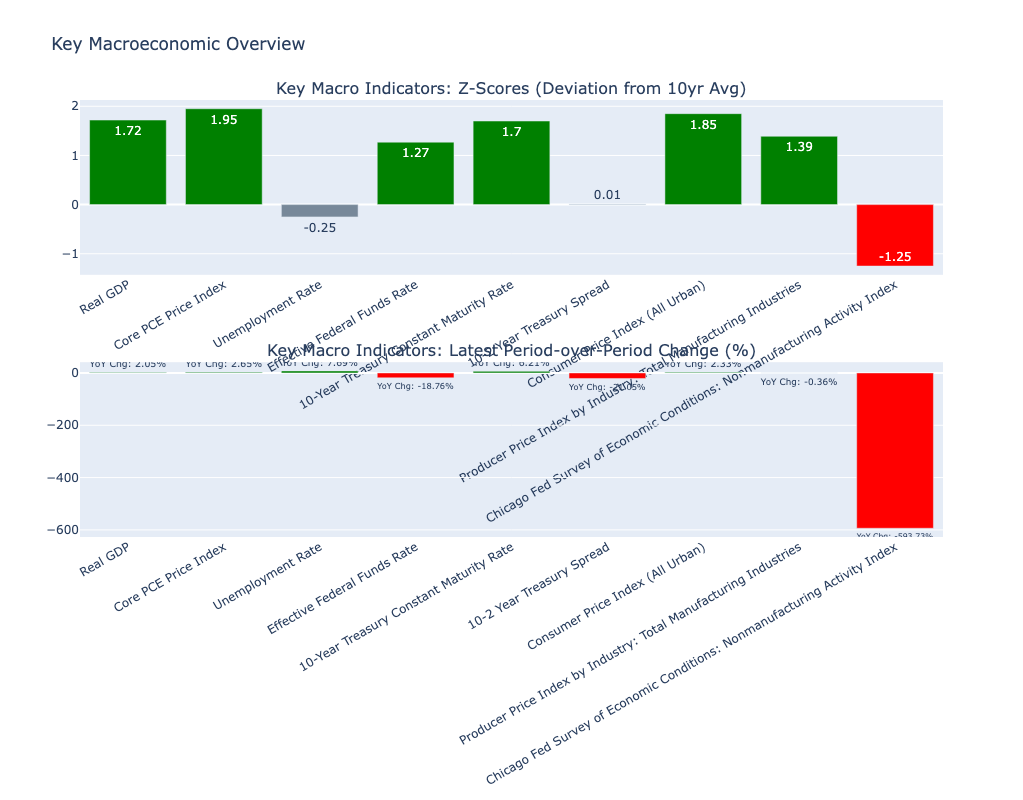


--- All Indicators Z-Score Ranking ---


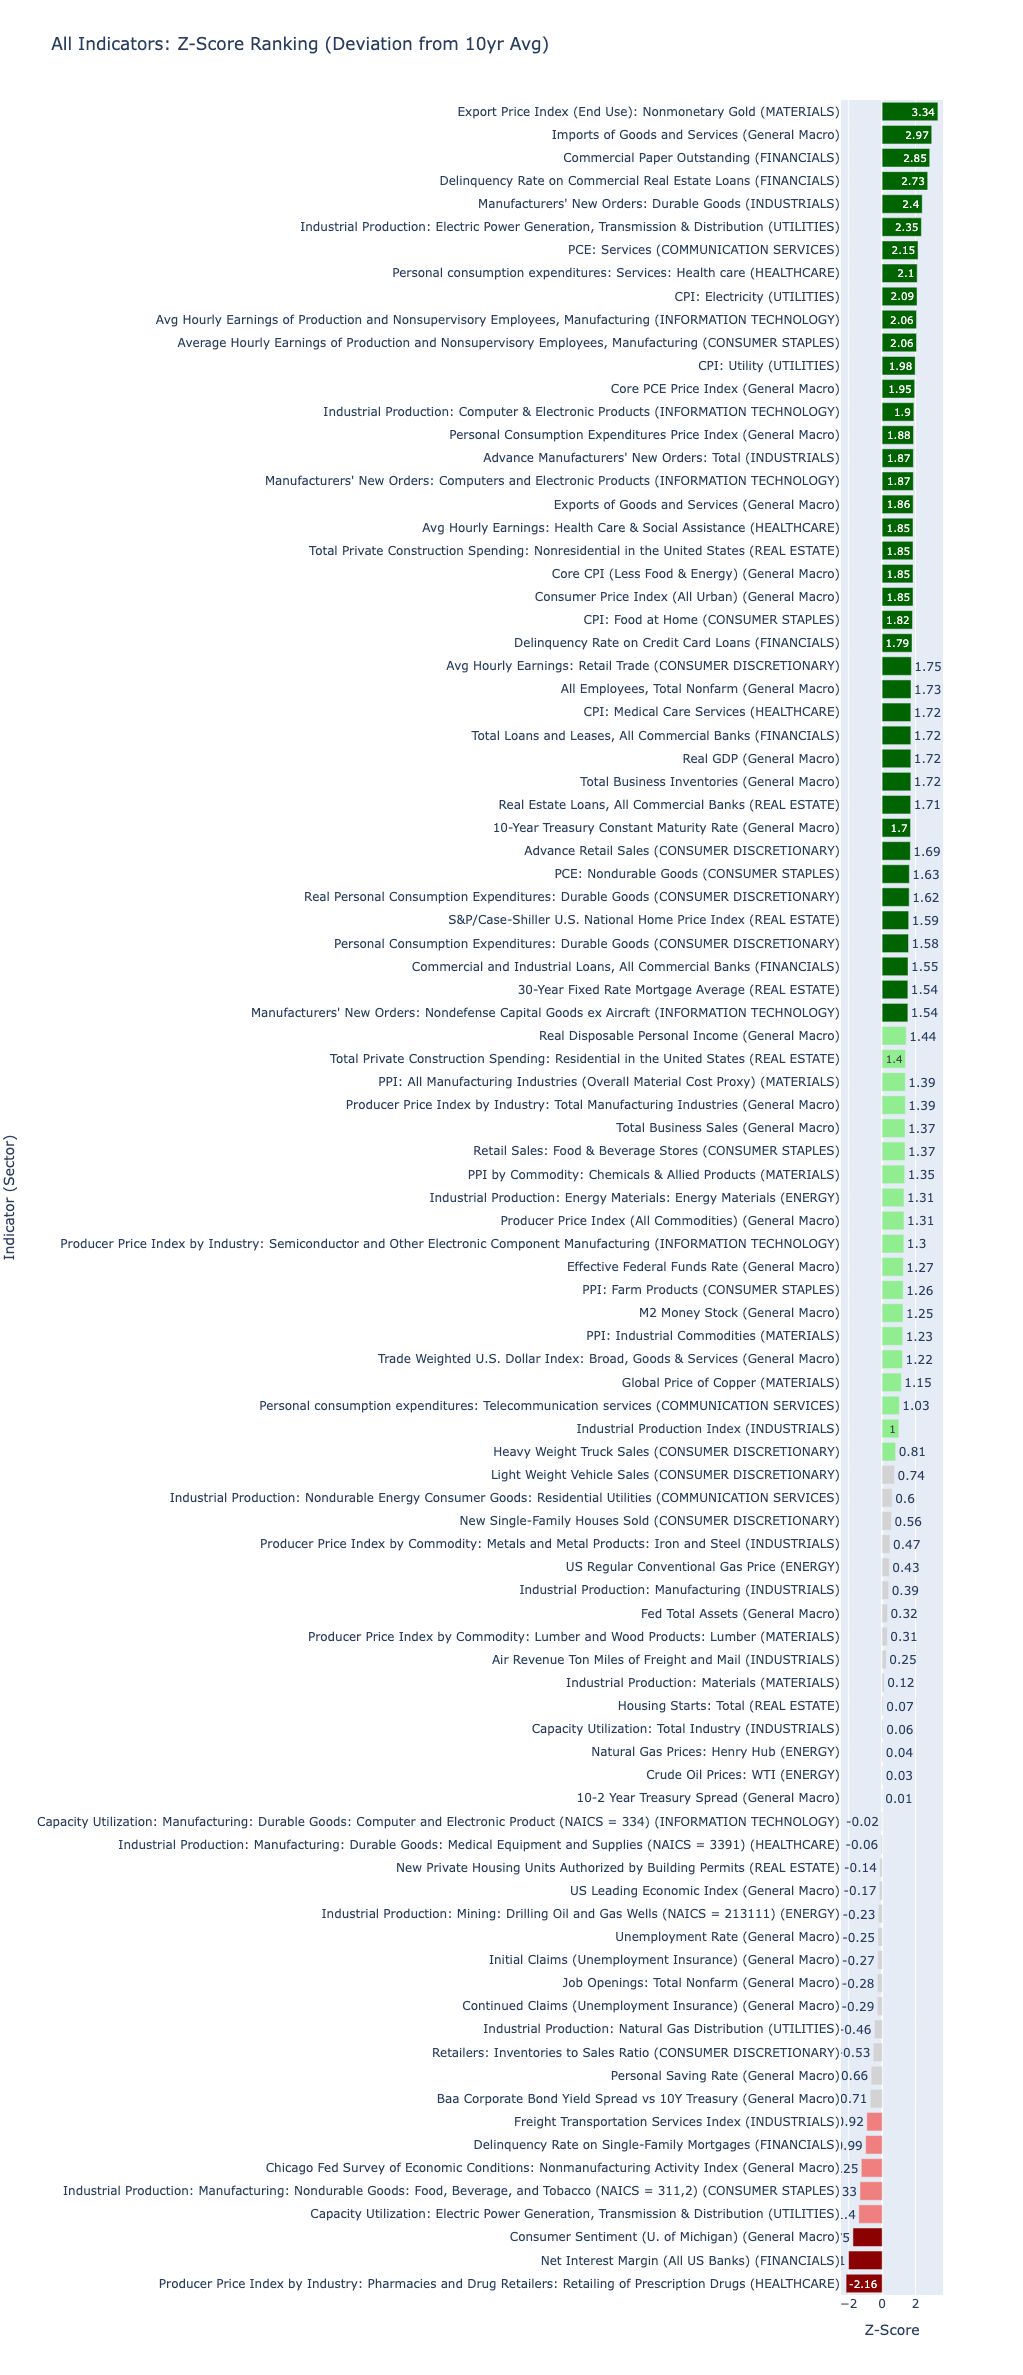


--- Sector Indicators Z-Score Heatmap ---


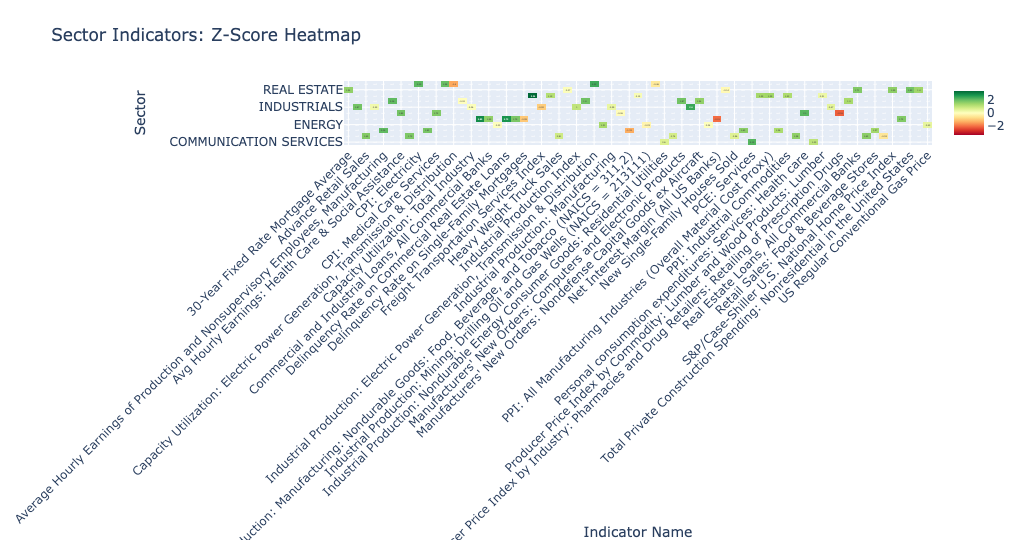


--- Average Z-Score by Sector ---


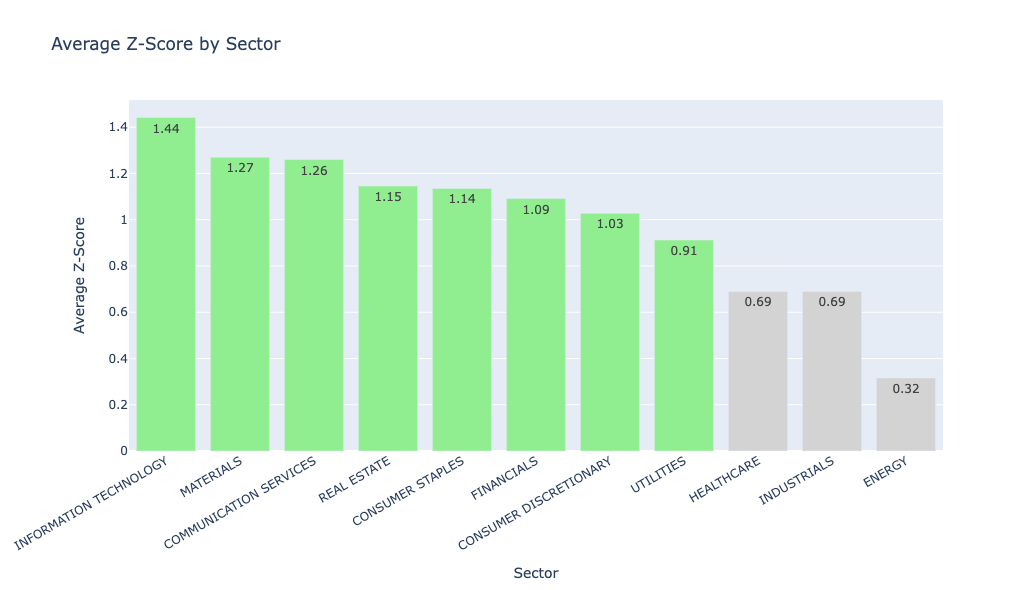

In [22]:
import re
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume 'full_report_string' is in the global scope from the previous cell execution
# For testing, you can uncomment and use this:
# try:
#     with open(REPORT_FILE_NAME, "r", encoding='utf-8') as f: # Use the correct REPORT_FILE_NAME
#         full_report_string = f.read()
# except NameError:
#     print("Error: REPORT_FILE_NAME not defined. Run previous cell or define it.")
#     full_report_string = ""
#     REPORT_FILE_NAME = "macro_sector_report_final_updated.txt" # Define for safety
# except FileNotFoundError:
#     print(f"Error: Report file '{REPORT_FILE_NAME}' not found. Run previous cell to generate it.")
#     full_report_string = ""


def parse_indicator_data(report_string):
    """
    Parses the report string to extract structured indicator data.
    """
    indicators_data = []
    current_sector = "General Macro" # Default for general indicators

    # Regex patterns to extract data
    # Match "Sector: SECTOR NAME" and allow for lines before it
    sector_pattern = re.compile(r"Sector:\s*([\w\s]+)")
    indicator_pattern = re.compile(r"Indicator:\s*(.*?)\s*\((\S+?)\)") # Name (ID)
    target_freq_pattern = re.compile(r"Target Freq:\s*(\S+)")
    latest_value_pattern = re.compile(r"Latest Value:\s*([\d\.\-N/AError]+)\s*(.*?)\s*\(as of ([\d\-]+)\)")
    yoy_change_pattern = re.compile(r"YoY Change:\s*([\d\.\-N/AError]+%?)")
    prev_period_label_pattern = re.compile(r"(\S+?)\s+Change:\s*([\d\.\-N/AError]+%?)") # Made label non-greedy
    z_score_pattern = re.compile(r"Z-Score:\s*([\d\.\-N/AError]+)")
    interpretation_pattern = re.compile(r"Interpretation:\s*(.*)")

    # Split the report by major sections first (General, then each Sector)
    # Heuristic: "II. SECTOR-SPECIFIC INDICATORS" and "Sector: " lines
    sections = re.split(r'(?=II\. SECTOR-SPECIFIC INDICATORS|Sector: )', report_string)
    
    for section_content in sections:
        if not section_content.strip():
            continue

        # Determine current sector for this section
        sector_match = sector_pattern.search(section_content)
        if sector_match:
            current_sector = sector_match.group(1).strip()
        elif "I. GENERAL MACROECONOMIC OVERVIEW" in section_content:
            current_sector = "General Macro"
        # If no explicit sector match in this block, it might be part of the previous one or general

        indicator_blocks = re.split(r'(?=Indicator: )', section_content)
        
        for block in indicator_blocks:
            if not block.strip() or not block.startswith("Indicator:"):
                continue

            data = {"sector": current_sector}

            ind_match = indicator_pattern.search(block)
            if ind_match:
                data["name"] = ind_match.group(1).strip()
                data["id"] = ind_match.group(2).strip()
            else:
                continue

            tf_match = target_freq_pattern.search(block)
            data["target_freq"] = tf_match.group(1) if tf_match else "N/A"

            lv_match = latest_value_pattern.search(block)
            if lv_match:
                data["latest_value_str"] = lv_match.group(1)
                data["unit"] = lv_match.group(2).strip()
                data["latest_date"] = lv_match.group(3)
            else:
                data["latest_value_str"] = "N/A"; data["unit"] = ""; data["latest_date"] = "N/A"

            yoy_match = yoy_change_pattern.search(block)
            data["yoy_change_str"] = yoy_match.group(1).replace('%', '') if yoy_match else "N/A"

            pp_match = prev_period_label_pattern.search(block)
            if pp_match:
                data["prev_period_label"] = pp_match.group(1)
                data["prev_period_change_str"] = pp_match.group(2).replace('%', '')
            else:
                data["prev_period_label"] = "Prev."; data["prev_period_change_str"] = "N/A"

            zs_match = z_score_pattern.search(block)
            data["z_score_str"] = zs_match.group(1) if zs_match else "N/A"
            
            interp_match = interpretation_pattern.search(block)
            data["interpretation"] = interp_match.group(1).strip() if interp_match else "N/A"

            for key in ["latest_value_str", "yoy_change_str", "prev_period_change_str", "z_score_str"]:
                new_key_num = key.replace("_str", "_num")
                val_str = data.get(key, "N/A")
                try:
                    data[new_key_num] = float(val_str)
                except ValueError:
                    data[new_key_num] = np.nan
            
            indicators_data.append(data)
            
    return pd.DataFrame(indicators_data)

# --- Parse the report string ---
if 'full_report_string' in locals() and full_report_string:
    df_report = parse_indicator_data(full_report_string)

    # Separate General Macro and Sector-Specific
    df_macro = df_report[df_report['sector'].str.upper() == "GENERAL MACRO"].copy()
    df_sectors = df_report[df_report['sector'].str.upper() != "GENERAL MACRO"].copy()
    
    if df_sectors.empty and not df_report[df_report['sector'].str.upper() == "GENERAL MACRO"].equals(df_report):
        print("Warning: df_sectors is empty, but there seems to be non-general macro data in df_report. Check parsing.")
        # For debugging, print unique sectors found:
        # print("Unique sectors found by parser:", df_report['sector'].unique())


else:
    print("full_report_string not found or empty. Please run the report generation cell first.")
    df_report = pd.DataFrame() 
    df_macro = pd.DataFrame()
    df_sectors = pd.DataFrame()

# --- Create Visualizations ---

# 1. Key Macro Indicators Overview (Z-scores and Period Change)
if not df_macro.empty:
    key_macro_ids = ["GDPC1", "PCEPILFE", "UNRATE", "FEDFUNDS", "DGS10", "T10Y2Y", "CPIAUCSL", "PCUOMFGOMFG", "CFSBCACTIVITYNMFG"]
    df_key_macro = df_macro[df_macro['id'].isin(key_macro_ids)].set_index('id').reindex(key_macro_ids).reset_index()
    df_key_macro.dropna(subset=['name'], inplace=True)

    if not df_key_macro.empty:
        fig_key_macro = make_subplots(
            rows=2, cols=1,
            shared_xaxes=False, # Keep false if x-axes are different scales/types
            vertical_spacing=0.2, # INCREASED SPACING
            subplot_titles=("Key Macro Indicators: Z-Scores (Deviation from 10yr Avg)",
                            "Key Macro Indicators: Latest Period-over-Period Change (%)")
        )

        colors_z = ['red' if z < -0.75 else ('green' if z > 0.75 else 'lightslategrey') for z in df_key_macro['z_score_num']]
        fig_key_macro.add_trace(go.Bar(
            x=df_key_macro['name'],
            y=df_key_macro['z_score_num'],
            marker_color=colors_z,
            text=df_key_macro['z_score_num'].round(2),
            textposition='auto',
            name='Z-Score'
        ), row=1, col=1)

        change_values = []
        change_labels = []
        for _, row in df_key_macro.iterrows():
            change_values.append(row['prev_period_change_num'])
            label_val = f"{row['prev_period_change_num']:.2f}%" if pd.notna(row['prev_period_change_num']) else "N/A"
            change_labels.append(f"{row['prev_period_label']} Chg: {label_val}")

        colors_change = ['red' if c < 0 else ('green' if c > 0 else 'lightslategrey') for c in change_values] # Using pd.Series for y
        fig_key_macro.add_trace(go.Bar(
            x=df_key_macro['name'],
            y=pd.to_numeric(pd.Series(change_values), errors='coerce'), # Ensure y is numeric series
            marker_color=colors_change,
            text=change_labels,
            textposition='outside',
            name='Period Change'
        ), row=2, col=1)
        
        fig_key_macro.update_layout(
            height=800, # Increased height
            title_text="Key Macroeconomic Overview",
            showlegend=False,
            margin=dict(t=100, b=120) # Adjust top/bottom margin for titles/labels
        )
        fig_key_macro.update_xaxes(tickangle= -30, row=1, col=1) # Angle ticks for subplot 1
        fig_key_macro.update_xaxes(tickangle= -30, row=2, col=1) # Angle ticks for subplot 2
        print("\n--- Key Macroeconomic Overview ---")
        fig_key_macro.show()
    else:
        print("No key macro indicators found after filtering. Check `key_macro_ids` and parsing.")
else:
    print("No general macro data found.")


# 2. All Indicators Z-Score Ranking
if not df_report.empty:
    df_sorted_z = df_report.dropna(subset=['z_score_num']).sort_values('z_score_num', ascending=False)
    
    def get_z_color(z):
        if pd.isna(z): return 'grey'
        if z > 1.5: return 'darkgreen'
        elif z > 0.75: return 'lightgreen'
        elif z < -1.5: return 'darkred'
        elif z < -0.75: return 'lightcoral'
        else: return 'lightgrey'
    
    df_sorted_z['color'] = df_sorted_z['z_score_num'].apply(get_z_color)

    if not df_sorted_z.empty:
        fig_all_z = go.Figure(go.Bar(
            y=df_sorted_z['name'] + ' (' + df_sorted_z['sector'] + ')',
            x=df_sorted_z['z_score_num'],
            marker_color=df_sorted_z['color'],
            orientation='h',
            text=df_sorted_z['z_score_num'].round(2),
            textposition='auto'
        ))
        fig_all_z.update_layout(
            height=max(800, len(df_sorted_z) * 25),
            title_text="All Indicators: Z-Score Ranking (Deviation from 10yr Avg)",
            xaxis_title="Z-Score",
            yaxis_title="Indicator (Sector)",
            yaxis=dict(autorange="reversed")
        )
        print("\n--- All Indicators Z-Score Ranking ---")
        fig_all_z.show()
    else:
        print("No data with valid Z-scores to rank.")
else:
    print("No report data to generate Z-score ranking.")

# 3. Sector Performance Snapshot
if not df_sectors.empty:
    df_sectors['z_score_num'] = pd.to_numeric(df_sectors['z_score_num'], errors='coerce')
    df_sectors_hm = df_sectors.dropna(subset=['sector', 'name', 'z_score_num']).copy()
    df_sectors_hm['metric_name'] = df_sectors_hm['name']

    # Heatmap
    try:
        heatmap_data = df_sectors_hm.pivot_table(
            index='sector', columns='metric_name', values='z_score_num'
        )
        if not heatmap_data.empty:
            fig_sector_heatmap = go.Figure(go.Heatmap(
                z=heatmap_data.values, x=heatmap_data.columns, y=heatmap_data.index,
                colorscale='RdYlGn', zmid=0, text=heatmap_data.round(2).values,
                texttemplate="%{text}", hoverongaps=False
            ))
            fig_sector_heatmap.update_layout(
                height=max(400, len(heatmap_data.index) * 40 + 100), # Adjusted dynamic height
                width=max(800, len(heatmap_data.columns) * 70 + 100), # Adjusted dynamic width
                title_text="Sector Indicators: Z-Score Heatmap",
                xaxis_title="Indicator Name", yaxis_title="Sector",
                xaxis_tickangle=-45,
                margin=dict(l=150, r=50, b=150, t=100) # Add margins for labels
            )
            print("\n--- Sector Indicators Z-Score Heatmap ---")
            fig_sector_heatmap.show()
        else:
            print("Not enough data for sector heatmap after pivoting.")
    except Exception as e:
        print(f"Could not generate sector heatmap: {e}")

    # Average Z-scores per Sector Bar Chart
    df_sector_avg_z = df_sectors.groupby('sector')['z_score_num'].mean().dropna().sort_values(ascending=False).reset_index()
    if not df_sector_avg_z.empty:
        df_sector_avg_z['color'] = df_sector_avg_z['z_score_num'].apply(get_z_color)
        fig_sector_avg_z = go.Figure(go.Bar(
            x=df_sector_avg_z['sector'], y=df_sector_avg_z['z_score_num'],
            marker_color=df_sector_avg_z['color'], text=df_sector_avg_z['z_score_num'].round(2),
            textposition='auto'
        ))
        fig_sector_avg_z.update_layout(
            height=max(500, len(df_sector_avg_z) * 40 + 150), # Dynamic height
            title_text="Average Z-Score by Sector",
            xaxis_title="Sector", yaxis_title="Average Z-Score",
            xaxis_tickangle=-30
        )
        print("\n--- Average Z-Score by Sector ---")
        fig_sector_avg_z.show()
    else:
        print("No data to calculate average Z-score by sector.")
elif df_report.empty:
    print("\nNo data was parsed from the report. Dashboard cannot be generated.")
else: # df_report is not empty, but df_sectors is
    print("\nNo sector-specific data was successfully parsed to visualize for sectors.")
    print("Please check the report string format and the parsing logic for sectors.")
    # You can print df_report['sector'].unique() here to see what sectors were parsed
    # print("Sectors parsed:", df_report['sector'].unique())